# 函式導入

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


# load data

In [29]:
# 定義 train_transforms，用於圖像預處理和數據增強
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),       # 調整圖像大小為 256x256
    transforms.RandomHorizontalFlip(),  # 隨機水平翻轉
    transforms.ToTensor(),              # 將圖像轉換為 Tensor 格式
    transforms.Normalize(mean=[0.3456398, 0.35234967, 0.34779571], std=[0.23318276, 0.23777122, 0.25202623]),  # 圖像標準化
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # 隨機調整亮度、對比度、飽和度和色相
])

# CarlaDataset 類，繼承自 PyTorch 的 Dataset
class CarlaDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None, target_size=(256, 256)):
        self.img_dir = img_dir  # 圖像目錄路徑
        self.mask_dir = mask_dir  # 掩膜目錄路徑，若不提供則為 None
        self.transform = transform  # 圖像預處理或增強操作
        self.target_size = target_size  # 圖像目標大小
        self.imgs = sorted(os.listdir(img_dir))  # 排序後的圖像檔案列表
        self.masks = sorted(os.listdir(mask_dir)) if mask_dir else None  # 掩膜檔案列表（若有）

    def __len__(self):
        return len(self.imgs)  # 返回圖像數量

    def __getitem__(self, idx):
        # 加載圖像並進行處理
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        image = Image.open(img_path).convert("RGB")  # 讀取圖像並轉換為 RGB 模式
        image = image.resize(self.target_size, Image.BILINEAR)  # 使用雙線性插值調整大小
        
        if self.transform:
            image = self.transform(image)  # 應用數據增強和預處理
        
        if self.mask_dir:
            # 若提供掩膜，則讀取並處理
            mask_path = os.path.join(self.mask_dir, self.masks[idx])
            mask = Image.open(mask_path).convert("L")  # 讀取掩膜並轉換為灰度模式
            mask = mask.resize(self.target_size, Image.NEAREST)  # 使用最近鄰插值調整大小
            mask = torch.tensor(np.array(mask), dtype=torch.long)  # 將掩膜轉為 Tensor 格式
            return image, mask  # 返回圖像與掩膜
        else:
            return image  # 僅返回圖像

# 建立訓練數據集
train_dataset = CarlaDataset(
    "C:/Users/asdzx/Desktop/hw2_dataset/train/imgs",  # 訓練圖像目錄
    "C:/Users/asdzx/Desktop/hw2_dataset/train/masks",  # 訓練掩膜目錄
    transform=train_transforms  # 應用的數據增強和預處理操作
)


設置路徑和數據加載


In [30]:
from torch.utils.data import random_split

# 設定訓練資料和驗證資料的比例
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

# 使用 random_split 來分割資料
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 建立 DataLoader
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(
    val_dataset, batch_size=8, shuffle=False)



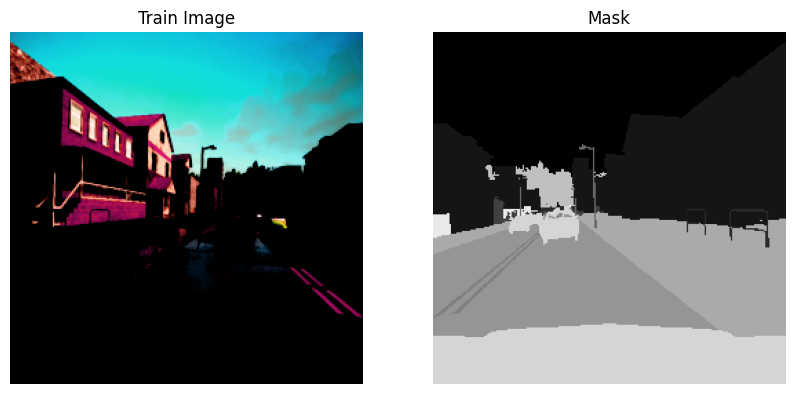

In [31]:
import matplotlib.pyplot as plt

# 隨機從訓練數據中取一個 batch
images, masks = next(iter(train_loader))

# 選擇 batch 中的第一張圖片和相應的遮罩
image = images[0]  # 第一張圖片
mask = masks[0].squeeze(0)    # 第一張圖片的遮罩，並移除單通道維度

# 將圖片從張量轉回到 numpy 陣列，並調整到 (H, W, C) 格式
image = image.permute(1, 2, 0).cpu().numpy()

# 顯示圖片和遮罩
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Train Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask.cpu().numpy(), cmap='gray')  # 使用灰度顯示單通道遮罩
plt.title("Mask")
plt.axis("off")

plt.show()


定義unet模型

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# SE 模塊
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # 全局平均池化，輸出尺寸固定為 (1, 1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)  # 第一個全連接層，通道數縮減
        self.relu = nn.ReLU(inplace=True)  # 激活函數
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)  # 第二個全連接層，恢復通道數
        self.sigmoid = nn.Sigmoid()  # 使用 Sigmoid 函數進行通道權重生成

    def forward(self, x):
        se = self.global_pool(x)  # 全局池化
        se = self.relu(self.fc1(se))  # 第一層全連接 + 激活
        se = self.sigmoid(self.fc2(se))  # 第二層全連接 + Sigmoid
        return x * se  # 將權重應用到原特徵圖上


# 改進 UNet 模型
class ImprovedUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(ImprovedUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # 編碼器部分
        self.inc = DoubleConv(n_channels, 64)  # 初始卷積模塊
        self.down1 = Down(64, 128)  # 下採樣1
        self.down2 = Down(128, 256)  # 下採樣2
        self.down3 = Down(256, 512)  # 下採樣3
        self.down4 = Down(512, 1024)  # 下採樣4
        self.dropout = nn.Dropout(p=0.4)  # 在 bottleneck 部分添加 Dropout 層

        # 添加 SE 模塊到 bottleneck
        self.seblock = SEBlock(1024)

        # 解碼器部分
        self.up1 = Up(1024 + 512, 512, bilinear)  # 上採樣1
        self.up2 = Up(512 + 256, 256, bilinear)  # 上採樣2
        self.up3 = Up(256 + 128, 128, bilinear)  # 上採樣3
        self.up4 = Up(128 + 64, 64, bilinear)  # 上採樣4

        # 最終輸出層
        self.outc = OutConv(64, n_classes)  # 將輸出調整為指定的類別數

    def forward(self, x):
        # 編碼器路徑
        x1 = self.inc(x)  # 初始卷積
        x2 = self.down1(x1)  # 下採樣1
        x3 = self.down2(x2)  # 下採樣2
        x4 = self.down3(x3)  # 下採樣3
        x5 = self.down4(x4)  # 下採樣4

        # Bottleneck 部分
        x_bottleneck = self.seblock(x5)  # 通道注意力機制
        x_bottleneck = self.dropout(x_bottleneck)  # 應用 Dropout

        # 解碼器路徑
        x = self.up1(x_bottleneck, x4)  # 上採樣1
        x = self.up2(x, x3)  # 上採樣2
        x = self.up3(x, x2)  # 上採樣3
        x = self.up4(x, x1)  # 上採樣4

        logits = self.outc(x)  # 輸出層
        return logits


# 定義 IoU 損失函數
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, preds, targets):
        smooth = 1e-5  # 防止分母為零
        preds = torch.softmax(preds, dim=1)  # 將預測轉為概率分佈
        targets_onehot = F.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2)  # 將目標轉為 one-hot 表示

        # 計算交集和聯集
        intersection = (preds * targets_onehot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_onehot.sum(dim=(2, 3)) - intersection

        # 計算 IoU
        iou = (intersection + smooth) / (union + smooth)
        return 1 - iou.mean()


# 混合損失函數
def mixed_loss_with_iou(outputs, targets, ce_weight=0.4, dice_weight=0.2, iou_weight=0.4):
    cross_entropy = nn.CrossEntropyLoss()(outputs, targets)  # 交叉熵損失
    dice_loss = DiceLoss()(outputs, targets)  # Dice 損失
    iou_loss = IoULoss()(outputs, targets)  # IoU 損失

    # 按權重加權混合
    return ce_weight * cross_entropy + dice_weight * dice_loss + iou_weight * iou_loss


In [34]:
# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedUNet(n_channels=3, n_classes=13, bilinear=True).to(device)

# 优化器与调度器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# 初始化权重
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# 混合精度训练工具
scaler = torch.cuda.amp.GradScaler()

C:\Users\asdzx\AppData\Local\Temp\ipykernel_33352\1024960951.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [35]:
from torchsummary import summary

# 假設你的模型名稱是 model
summary(model, input_size=(3, 256, 256))  # 假設輸入大小為 256x256 RGB 圖片

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
           Dropout-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 256, 256]          36,928
       BatchNorm2d-6         [-1, 64, 256, 256]             128
              ReLU-7         [-1, 64, 256, 256]               0
           Dropout-8         [-1, 64, 256, 256]               0
        DoubleConv-9         [-1, 64, 256, 256]               0
        MaxPool2d-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]          73,856
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
          Dropout-14        [-1, 128, 1

In [36]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


模型訓練

In [40]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def train_model(
    model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=15, best_model_path="best_model.pth"
):
    best_val_loss = float("inf")
    train_history = {"loss": [], "accuracy": []}
    val_history = {"loss": [], "accuracy": []}
    scaler = torch.cuda.amp.GradScaler()  # 初始化混合精度縮放器

    for epoch in range(num_epochs):
        model.train()  # 設定模型為訓練模式
        running_loss = 0.0
        total_correct = 0
        total_pixels = 0

        # 训练阶段
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()  # 清空梯度

            # 前向传播
            with torch.amp.autocast(device_type='cuda'):  # 混合精度訓練
                logits = model(images)
                loss = mixed_loss_with_iou(logits, masks)  # 使用混合損失函數（含 IoU）

            # 反向传播
            scaler.scale(loss).backward()  # 反向傳播
            scaler.step(optimizer)  # 更新權重
            scaler.update()  # 更新混合精度縮放器

            running_loss += loss.item()

            # 计算准确率
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)

        # 計算訓練損失和準確率
        train_loss = running_loss / len(train_loader)
        train_accuracy = (total_correct / total_pixels) * 100 if total_pixels > 0 else 0
        train_history["loss"].append(train_loss)
        train_history["accuracy"].append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Training Accuracy: {train_accuracy:.2f}%")

        # 验证阶段
        model.eval()  # 設定模型為驗證模式
        val_loss = 0.0
        val_correct = 0
        val_pixels = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                logits = model(images)
                loss = mixed_loss(logits, masks)
                val_loss += loss.item()

                # 计算验证准确率
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == masks).sum().item()
                val_pixels += torch.numel(masks)

        # 計算驗證損失和準確率
        val_loss /= len(val_loader)
        val_accuracy = (val_correct / val_pixels) * 100 if val_pixels > 0 else 0
        val_history["loss"].append(val_loss)
        val_history["accuracy"].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%")

        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at {best_model_path} with Validation Loss: {val_loss:.4f}")

        # 调整学习率
        scheduler.step()

        # 清空顯存
        torch.cuda.empty_cache()
        print(f"Epoch {epoch+1}/{num_epochs} finished. CUDA cache cleared.")

    return train_history, val_history


# 调用训练函数
train_history, val_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=50,
    best_model_path="best_model.pth"
)


C:\Users\asdzx\AppData\Local\Temp\ipykernel_33352\610623625.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # 初始化混合精度縮放器
Epoch 1/50 - Training: 100%|██████████| 507/507 [02:56<00:00,  2.88it/s]


Epoch 1/50 - Training Loss: 0.4553 - Training Accuracy: 89.55%
Epoch 1/50 - Validation Loss: 0.6048 - Validation Accuracy: 82.98%
Best model saved at best_model.pth with Validation Loss: 0.6048
Epoch 1/50 finished. CUDA cache cleared.


Epoch 2/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 2/50 - Training Loss: 0.4531 - Training Accuracy: 89.60%
Epoch 2/50 - Validation Loss: 0.6094 - Validation Accuracy: 82.94%
Epoch 2/50 finished. CUDA cache cleared.


Epoch 3/50 - Training: 100%|██████████| 507/507 [02:53<00:00,  2.91it/s]


Epoch 3/50 - Training Loss: 0.4479 - Training Accuracy: 89.72%
Epoch 3/50 - Validation Loss: 0.5970 - Validation Accuracy: 84.16%
Best model saved at best_model.pth with Validation Loss: 0.5970
Epoch 3/50 finished. CUDA cache cleared.


Epoch 4/50 - Training: 100%|██████████| 507/507 [02:53<00:00,  2.92it/s]


Epoch 4/50 - Training Loss: 0.4391 - Training Accuracy: 90.08%
Epoch 4/50 - Validation Loss: 0.5768 - Validation Accuracy: 84.00%
Best model saved at best_model.pth with Validation Loss: 0.5768
Epoch 4/50 finished. CUDA cache cleared.


Epoch 5/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 5/50 - Training Loss: 0.4408 - Training Accuracy: 89.95%
Epoch 5/50 - Validation Loss: 0.5118 - Validation Accuracy: 85.96%
Best model saved at best_model.pth with Validation Loss: 0.5118
Epoch 5/50 finished. CUDA cache cleared.


Epoch 6/50 - Training: 100%|██████████| 507/507 [02:53<00:00,  2.92it/s]


Epoch 6/50 - Training Loss: 0.4237 - Training Accuracy: 90.57%
Epoch 6/50 - Validation Loss: 0.4844 - Validation Accuracy: 86.68%
Best model saved at best_model.pth with Validation Loss: 0.4844
Epoch 6/50 finished. CUDA cache cleared.


Epoch 7/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 7/50 - Training Loss: 0.4127 - Training Accuracy: 91.00%
Epoch 7/50 - Validation Loss: 0.5728 - Validation Accuracy: 84.45%
Epoch 7/50 finished. CUDA cache cleared.


Epoch 8/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 8/50 - Training Loss: 0.4059 - Training Accuracy: 91.19%
Epoch 8/50 - Validation Loss: 0.4920 - Validation Accuracy: 86.56%
Epoch 8/50 finished. CUDA cache cleared.


Epoch 9/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 9/50 - Training Loss: 0.3973 - Training Accuracy: 91.48%
Epoch 9/50 - Validation Loss: 0.5702 - Validation Accuracy: 85.69%
Epoch 9/50 finished. CUDA cache cleared.


Epoch 10/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 10/50 - Training Loss: 0.3875 - Training Accuracy: 91.83%
Epoch 10/50 - Validation Loss: 0.5491 - Validation Accuracy: 86.60%
Epoch 10/50 finished. CUDA cache cleared.


Epoch 11/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.90it/s]


Epoch 11/50 - Training Loss: 0.3829 - Training Accuracy: 91.98%
Epoch 11/50 - Validation Loss: 0.6084 - Validation Accuracy: 85.62%
Epoch 11/50 finished. CUDA cache cleared.


Epoch 12/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 12/50 - Training Loss: 0.3757 - Training Accuracy: 92.25%
Epoch 12/50 - Validation Loss: 0.6274 - Validation Accuracy: 85.68%
Epoch 12/50 finished. CUDA cache cleared.


Epoch 13/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 13/50 - Training Loss: 0.3725 - Training Accuracy: 92.36%
Epoch 13/50 - Validation Loss: 0.6073 - Validation Accuracy: 86.24%
Epoch 13/50 finished. CUDA cache cleared.


Epoch 14/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 14/50 - Training Loss: 0.3660 - Training Accuracy: 92.61%
Epoch 14/50 - Validation Loss: 0.6068 - Validation Accuracy: 86.33%
Epoch 14/50 finished. CUDA cache cleared.


Epoch 15/50 - Training: 100%|██████████| 507/507 [02:53<00:00,  2.92it/s]


Epoch 15/50 - Training Loss: 0.3682 - Training Accuracy: 92.53%
Epoch 15/50 - Validation Loss: 0.6031 - Validation Accuracy: 86.09%
Epoch 15/50 finished. CUDA cache cleared.


Epoch 16/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 16/50 - Training Loss: 0.3675 - Training Accuracy: 92.56%
Epoch 16/50 - Validation Loss: 0.6008 - Validation Accuracy: 86.24%
Epoch 16/50 finished. CUDA cache cleared.


Epoch 17/50 - Training: 100%|██████████| 507/507 [02:53<00:00,  2.92it/s]


Epoch 17/50 - Training Loss: 0.3680 - Training Accuracy: 92.52%
Epoch 17/50 - Validation Loss: 0.5618 - Validation Accuracy: 87.17%
Epoch 17/50 finished. CUDA cache cleared.


Epoch 18/50 - Training: 100%|██████████| 507/507 [02:54<00:00,  2.91it/s]


Epoch 18/50 - Training Loss: 0.3713 - Training Accuracy: 92.37%
Epoch 18/50 - Validation Loss: 0.6232 - Validation Accuracy: 85.97%
Epoch 18/50 finished. CUDA cache cleared.


Epoch 19/50 - Training: 100%|██████████| 507/507 [02:53<00:00,  2.92it/s]


Epoch 19/50 - Training Loss: 0.3737 - Training Accuracy: 92.27%
Epoch 19/50 - Validation Loss: 0.5370 - Validation Accuracy: 87.11%
Epoch 19/50 finished. CUDA cache cleared.


Epoch 20/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.93it/s]


Epoch 20/50 - Training Loss: 0.3759 - Training Accuracy: 92.21%
Epoch 20/50 - Validation Loss: 0.5331 - Validation Accuracy: 87.07%
Epoch 20/50 finished. CUDA cache cleared.


Epoch 21/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.93it/s]


Epoch 21/50 - Training Loss: 0.3836 - Training Accuracy: 91.90%
Epoch 21/50 - Validation Loss: 0.7170 - Validation Accuracy: 84.82%
Epoch 21/50 finished. CUDA cache cleared.


Epoch 22/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 22/50 - Training Loss: 0.3833 - Training Accuracy: 91.91%
Epoch 22/50 - Validation Loss: 0.5070 - Validation Accuracy: 87.70%
Epoch 22/50 finished. CUDA cache cleared.


Epoch 23/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 23/50 - Training Loss: 0.3808 - Training Accuracy: 91.99%
Epoch 23/50 - Validation Loss: 0.4751 - Validation Accuracy: 86.94%
Best model saved at best_model.pth with Validation Loss: 0.4751
Epoch 23/50 finished. CUDA cache cleared.


Epoch 24/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 24/50 - Training Loss: 0.3817 - Training Accuracy: 91.93%
Epoch 24/50 - Validation Loss: 0.6539 - Validation Accuracy: 84.97%
Epoch 24/50 finished. CUDA cache cleared.


Epoch 25/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.95it/s]


Epoch 25/50 - Training Loss: 0.3812 - Training Accuracy: 91.94%
Epoch 25/50 - Validation Loss: 0.4664 - Validation Accuracy: 87.86%
Best model saved at best_model.pth with Validation Loss: 0.4664
Epoch 25/50 finished. CUDA cache cleared.


Epoch 26/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 26/50 - Training Loss: 0.3734 - Training Accuracy: 92.23%
Epoch 26/50 - Validation Loss: 0.4890 - Validation Accuracy: 87.06%
Epoch 26/50 finished. CUDA cache cleared.


Epoch 27/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 27/50 - Training Loss: 0.3710 - Training Accuracy: 92.30%
Epoch 27/50 - Validation Loss: 0.4577 - Validation Accuracy: 88.04%
Best model saved at best_model.pth with Validation Loss: 0.4577
Epoch 27/50 finished. CUDA cache cleared.


Epoch 28/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 28/50 - Training Loss: 0.3635 - Training Accuracy: 92.55%
Epoch 28/50 - Validation Loss: 0.5690 - Validation Accuracy: 86.83%
Epoch 28/50 finished. CUDA cache cleared.


Epoch 29/50 - Training: 100%|██████████| 507/507 [02:51<00:00,  2.95it/s]


Epoch 29/50 - Training Loss: 0.3595 - Training Accuracy: 92.75%
Epoch 29/50 - Validation Loss: 0.4145 - Validation Accuracy: 89.13%
Best model saved at best_model.pth with Validation Loss: 0.4145
Epoch 29/50 finished. CUDA cache cleared.


Epoch 30/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 30/50 - Training Loss: 0.3511 - Training Accuracy: 93.05%
Epoch 30/50 - Validation Loss: 0.3670 - Validation Accuracy: 90.52%
Best model saved at best_model.pth with Validation Loss: 0.3670
Epoch 30/50 finished. CUDA cache cleared.


Epoch 31/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 31/50 - Training Loss: 0.3469 - Training Accuracy: 93.16%
Epoch 31/50 - Validation Loss: 0.3537 - Validation Accuracy: 90.16%
Best model saved at best_model.pth with Validation Loss: 0.3537
Epoch 31/50 finished. CUDA cache cleared.


Epoch 32/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 32/50 - Training Loss: 0.3419 - Training Accuracy: 93.35%
Epoch 32/50 - Validation Loss: 0.3332 - Validation Accuracy: 91.11%
Best model saved at best_model.pth with Validation Loss: 0.3332
Epoch 32/50 finished. CUDA cache cleared.


Epoch 33/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.95it/s]


Epoch 33/50 - Training Loss: 0.3363 - Training Accuracy: 93.55%
Epoch 33/50 - Validation Loss: 0.4053 - Validation Accuracy: 89.44%
Epoch 33/50 finished. CUDA cache cleared.


Epoch 34/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 34/50 - Training Loss: 0.3373 - Training Accuracy: 93.54%
Epoch 34/50 - Validation Loss: 0.3686 - Validation Accuracy: 90.48%
Epoch 34/50 finished. CUDA cache cleared.


Epoch 35/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.93it/s]


Epoch 35/50 - Training Loss: 0.3331 - Training Accuracy: 93.65%
Epoch 35/50 - Validation Loss: 0.3768 - Validation Accuracy: 90.27%
Epoch 35/50 finished. CUDA cache cleared.


Epoch 36/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 36/50 - Training Loss: 0.3370 - Training Accuracy: 93.52%
Epoch 36/50 - Validation Loss: 0.3822 - Validation Accuracy: 90.08%
Epoch 36/50 finished. CUDA cache cleared.


Epoch 37/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 37/50 - Training Loss: 0.3387 - Training Accuracy: 93.45%
Epoch 37/50 - Validation Loss: 0.3962 - Validation Accuracy: 89.86%
Epoch 37/50 finished. CUDA cache cleared.


Epoch 38/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 38/50 - Training Loss: 0.3379 - Training Accuracy: 93.48%
Epoch 38/50 - Validation Loss: 0.3935 - Validation Accuracy: 90.01%
Epoch 38/50 finished. CUDA cache cleared.


Epoch 39/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.93it/s]


Epoch 39/50 - Training Loss: 0.3398 - Training Accuracy: 93.39%
Epoch 39/50 - Validation Loss: 0.3446 - Validation Accuracy: 90.59%
Epoch 39/50 finished. CUDA cache cleared.


Epoch 40/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 40/50 - Training Loss: 0.3420 - Training Accuracy: 93.33%
Epoch 40/50 - Validation Loss: 0.4179 - Validation Accuracy: 89.19%
Epoch 40/50 finished. CUDA cache cleared.


Epoch 41/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.93it/s]


Epoch 41/50 - Training Loss: 0.3478 - Training Accuracy: 93.08%
Epoch 41/50 - Validation Loss: 0.3604 - Validation Accuracy: 90.76%
Epoch 41/50 finished. CUDA cache cleared.


Epoch 42/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.93it/s]


Epoch 42/50 - Training Loss: 0.3506 - Training Accuracy: 93.00%
Epoch 42/50 - Validation Loss: 0.4120 - Validation Accuracy: 89.38%
Epoch 42/50 finished. CUDA cache cleared.


Epoch 43/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 43/50 - Training Loss: 0.3528 - Training Accuracy: 92.91%
Epoch 43/50 - Validation Loss: 0.4376 - Validation Accuracy: 89.22%
Epoch 43/50 finished. CUDA cache cleared.


Epoch 44/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 44/50 - Training Loss: 0.3535 - Training Accuracy: 92.89%
Epoch 44/50 - Validation Loss: 0.3920 - Validation Accuracy: 90.12%
Epoch 44/50 finished. CUDA cache cleared.


Epoch 45/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 45/50 - Training Loss: 0.3501 - Training Accuracy: 93.00%
Epoch 45/50 - Validation Loss: 0.3113 - Validation Accuracy: 91.60%
Best model saved at best_model.pth with Validation Loss: 0.3113
Epoch 45/50 finished. CUDA cache cleared.


Epoch 46/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.95it/s]


Epoch 46/50 - Training Loss: 0.3480 - Training Accuracy: 93.07%
Epoch 46/50 - Validation Loss: 0.3561 - Validation Accuracy: 90.49%
Epoch 46/50 finished. CUDA cache cleared.


Epoch 47/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Epoch 47/50 - Training Loss: 0.3432 - Training Accuracy: 93.24%
Epoch 47/50 - Validation Loss: 0.3588 - Validation Accuracy: 90.40%
Epoch 47/50 finished. CUDA cache cleared.


Epoch 48/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.93it/s]


Epoch 48/50 - Training Loss: 0.3383 - Training Accuracy: 93.43%
Epoch 48/50 - Validation Loss: 0.3050 - Validation Accuracy: 91.64%
Best model saved at best_model.pth with Validation Loss: 0.3050
Epoch 48/50 finished. CUDA cache cleared.


Epoch 49/50 - Training: 100%|██████████| 507/507 [02:51<00:00,  2.95it/s]


Epoch 49/50 - Training Loss: 0.3348 - Training Accuracy: 93.50%
Epoch 49/50 - Validation Loss: 0.3155 - Validation Accuracy: 91.65%
Epoch 49/50 finished. CUDA cache cleared.


Epoch 50/50 - Training: 100%|██████████| 507/507 [02:52<00:00,  2.93it/s]


Epoch 50/50 - Training Loss: 0.3306 - Training Accuracy: 93.64%
Epoch 50/50 - Validation Loss: 0.2818 - Validation Accuracy: 92.36%
Best model saved at best_model.pth with Validation Loss: 0.2818
Epoch 50/50 finished. CUDA cache cleared.


In [41]:
# 絕對路徑設置
best_model_path = os.path.expanduser("~/Desktop/best_model.pth")
# 載入模型
model.load_state_dict(torch.load(best_model_path, map_location=device))

C:\Users\asdzx\AppData\Local\Temp\ipykernel_33352\3090318249.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locati

<All keys matched successfully>

# Inference Test Set & Save Prediction Masks

In [42]:
from PIL import Image
import numpy as np
import torch.nn.functional as F

# 設定測試圖片路徑和預測結果儲存路徑
test_path = os.path.expanduser("~/Desktop/hw2_dataset/test/imgs")
save_path = os.path.expanduser("~/Desktop/hw2_dataset/test/preds")

test_transform = transforms.Compose([
                 transforms.Resize((256, 256)),
                 transforms.ToTensor()])

if not os.path.exists(save_path):
        os.makedirs(save_path)


model.eval()  # 將模型設為評估模式
with torch.no_grad():  # 禁用梯度計算
# 使用 tqdm 顯示進度條，迭代測試圖片
        for img_id in tqdm(os.listdir(test_path), desc="Testing images", unit="image"):
                img_path = os.path.join(test_path, img_id)
                img = Image.open(img_path)
                img = test_transform(img)
                img = img.unsqueeze(0).to(device)
                
                # 進行前向傳播
                logits = model(img)  # 只取主輸出 logits
                output = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
                # Cvt to Image
                output_img = Image.fromarray(output, mode='L')
                output_img_resized = output_img.resize((800, 600), resample=Image.NEAREST)
                output_img_resized.save(os.path.join(save_path, img_id))

Testing images: 100%|██████████| 500/500 [00:15<00:00, 31.77image/s]


# Convert Masks to `RLE format` & Generate submission.csv

In [43]:
import os
import cv2
import csv
import numpy as np

"""
This script is used to generate submission.csv for hw2.

Note: Predicted masks must be grayscale(1-channel).
"""

pred_mask_dir = os.path.expanduser("~/Desktop/hw2_dataset/test/preds")
save_csv_path = os.path.expanduser("~/Desktop/hw2_dataset/test/submission.csv")


def rle_encoding(mask: np.ndarray, class_id: int) -> str:
    binary_mask = (mask == class_id).astype(np.uint8)
    pixels = binary_mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs) if runs.size > 1 else 'none'
def generate_submission_csv():
    all_masks = []
    for filename in os.listdir(pred_mask_dir):
        if filename.endswith('.png'):
            all_masks.append(os.path.join(pred_mask_dir, filename))

    # 將文件按名稱排序，假設文件名格式為 "1.png" 到 "500.png"
    all_masks.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

    with open(save_csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        header = ['img_id'] + [f'class_{i}' for i in range(13)]
        writer.writerow(header)
        for mask_path in all_masks:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask_name = os.path.basename(mask_path)
            rle_encodings = {}
            for class_id in range(13):
                rle_encoded = rle_encoding(mask, class_id)
                rle_encodings[class_id] = rle_encoded
            rows = [mask_name] + [rle_encodings[class_id] for class_id in range(13)]
            writer.writerow(rows)

generate_submission_csv()